In [73]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pyfolio as pf

plt.style.use('bmh')

/Users/danieloliveira/opt/anaconda3/envs/dcuoliveira/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
current_dir = os.getcwd()

target_file = "gdp_cpi_yield10.xlsx"
start_date = "2008-01-01"

data = pd.read_excel(os.path.join(current_dir, "data", target_file))
data.rename(columns={"TY1": "U.S. 10y Yield", "GDP-REV": "E[GDP]", "CPI-REV": "E[CPI]"}, inplace=True)
data.tail()

,date,E[GDP],E[CPI],U.S. 10y Yield,Close
3865,2021-10-25,4.276587,3.478968,1.6307,NaN
3866,2021-10-26,4.269841,3.474603,1.6079,NaN
3867,2021-10-27,4.263095,3.470238,1.5413,NaN
3868,2021-10-28,4.256349,3.465873,1.5800,NaN
3869,2021-10-29,4.249603,3.461508,1.5521,NaN


In [3]:
data = data[["date", "E[GDP]", "E[CPI]", "U.S. 10y Yield"]]
data.set_index("date", inplace=True)
data = data.loc[start_date:]

data_daily = data.resample("B").mean()
data_weekly = data.resample("W-FRI").last()

<AxesSubplot:xlabel='date'>

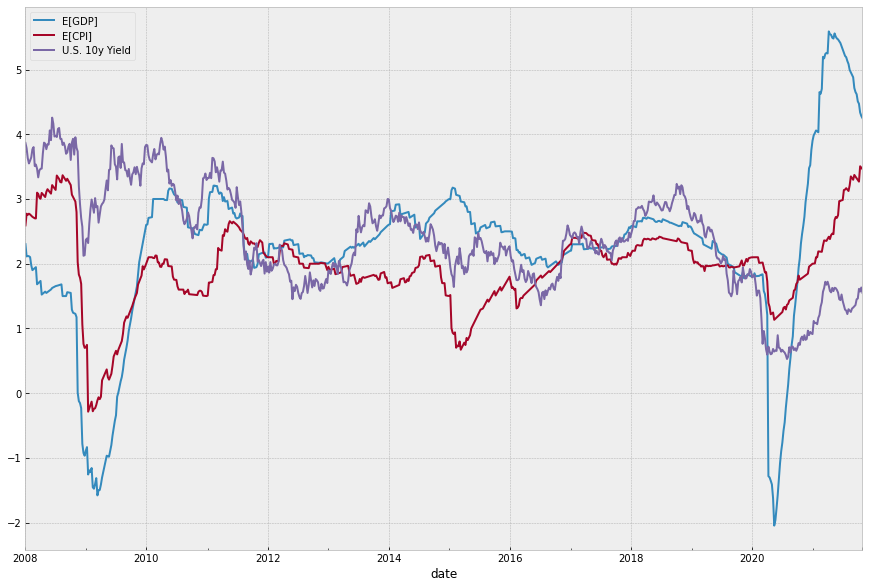

In [4]:
data_weekly.plot(figsize=(15, 10))

<AxesSubplot:xlabel='date'>

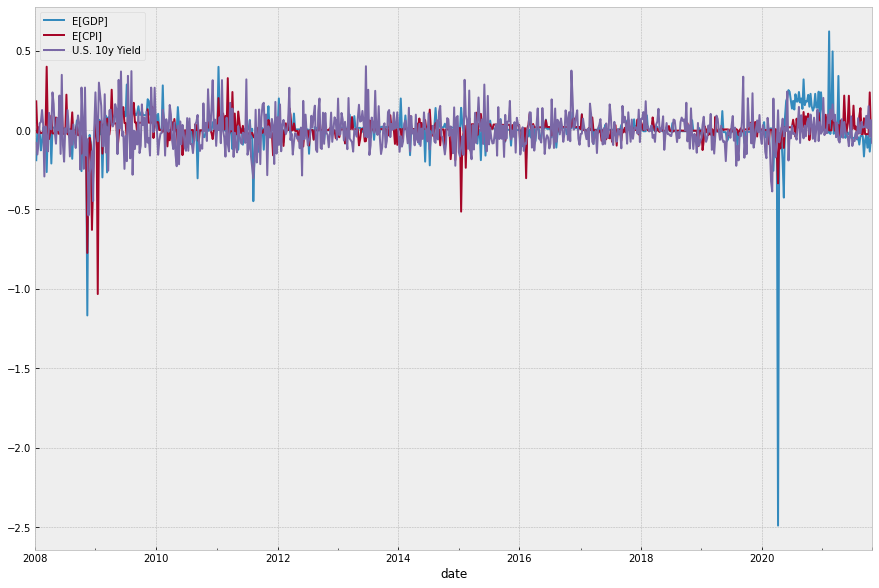

In [5]:
data_weekly.diff().plot(figsize=(15, 10))

## Static VAR model

### 1. Weekly VAR(2) model

In [8]:
var2_weekly_mod = VAR(data_weekly.diff().dropna())
var2_weekly_results = var2_weekly_mod.fit(2)
var2_weekly_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Nov, 2021
Time:                     10:37:05
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -13.4508
Nobs:                     719.000    HQIC:                  -13.5329
Log likelihood:           1843.98    FPE:                1.25987e-06
AIC:                     -13.5845    Det(Omega_mle):     1.22378e-06
--------------------------------------------------------------------
Results for equation E[GDP]
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.002444         0.004865            0.502           0.615
L1.E[GDP]                 0.140767         0.040093            3.511           0.000
L1.E[CPI]                 0.106183         

### 2. Weekly VAR(4) model

In [9]:
var4_weekly_mod = VAR(data_weekly.diff().dropna())
var4_weekly_results = var4_weekly_mod.fit(4)
var4_weekly_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Nov, 2021
Time:                     10:37:29
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -13.5189
Nobs:                     717.000    HQIC:                  -13.6716
Log likelihood:           1922.59    FPE:                1.04895e-06
AIC:                     -13.7677    Det(Omega_mle):     9.93904e-07
--------------------------------------------------------------------
Results for equation E[GDP]
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.001879         0.004702            0.400           0.689
L1.E[GDP]                 0.100179         0.039225            2.554           0.011
L1.E[CPI]                 0.092077         

### 3. Weekly VAR(8) model

In [11]:
var8_weekly_mod = VAR(data_weekly.diff().dropna())
var8_weekly_results = var8_weekly_mod.fit(8)
var8_weekly_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Nov, 2021
Time:                     10:39:15
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -13.3370
Nobs:                     713.000    HQIC:                  -13.6320
Log likelihood:           1965.90    FPE:                9.97904e-07
AIC:                     -13.8177    Det(Omega_mle):     8.99888e-07
--------------------------------------------------------------------
Results for equation E[GDP]
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.002899         0.004643            0.624           0.532
L1.E[GDP]                 0.058836         0.040342            1.458           0.145
L1.E[CPI]                 0.090421         

### 4. Weekly VAR(2) model with COVID dummy

In [12]:
data_weekly["covid_dummy"] = 0
data_weekly.loc["2020-04-10", "covid_dummy"] = 1

data_weekly_covid = pd.concat([data_weekly.drop("covid_dummy", axis=1).diff(), data_weekly[["covid_dummy"]]], axis=1).dropna()

In [13]:
var2_weekly_covid_mod = VAR(endog=data_weekly_covid.drop("covid_dummy", axis=1),
                            exog=data_weekly_covid[["covid_dummy"]])
var2_weekly_covid_results = var2_weekly_covid_mod.fit(2)
var2_weekly_covid_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Nov, 2021
Time:                     10:40:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -14.1355
Nobs:                     719.000    HQIC:                  -14.2293
Log likelihood:           2100.00    FPE:                6.23249e-07
AIC:                     -14.2883    Det(Omega_mle):     6.02900e-07
--------------------------------------------------------------------
Results for equation E[GDP]
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.005805         0.003477            1.669           0.095
covid_dummy              -2.447296         0.093543          -26.162           0.000
L1.E[GDP]                 0.124413         

### 4. Weekly VAR(4) model with COVID dummy

In [14]:
var4_weekly_covid_mod = VAR(endog=data_weekly_covid.drop("covid_dummy", axis=1),
                            exog=data_weekly_covid[["covid_dummy"]])
var4_weekly_covid_results = var4_weekly_covid_mod.fit(4)
var4_weekly_covid_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Nov, 2021
Time:                     10:41:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -14.2380
Nobs:                     717.000    HQIC:                  -14.4025
Log likelihood:           2190.25    FPE:                5.01351e-07
AIC:                     -14.5060    Det(Omega_mle):     4.73094e-07
--------------------------------------------------------------------
Results for equation E[GDP]
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.005466         0.003281            1.666           0.096
covid_dummy              -2.416010         0.088532          -27.290           0.000
L1.E[GDP]                 0.083853         

### 45 Weekly VAR(8) model with COVID dummy

In [16]:
var8_weekly_covid_mod = VAR(endog=data_weekly_covid.drop("covid_dummy", axis=1),
                            exog=data_weekly_covid[["covid_dummy"]])
var8_weekly_covid_results = var8_weekly_covid_mod.fit(8)
var8_weekly_covid_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Nov, 2021
Time:                     10:43:00
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -14.0821
Nobs:                     713.000    HQIC:                  -14.3890
Log likelihood:           2241.38    FPE:                4.64672e-07
AIC:                     -14.5820    Det(Omega_mle):     4.17332e-07
--------------------------------------------------------------------
Results for equation E[GDP]
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.005607         0.003191            1.757           0.079
covid_dummy              -2.413571         0.086953          -27.757           0.000
L1.E[GDP]                 0.038498         